# SMILES dataset

Learn to auto-encode chemical molecules encoded as SMILES strings. In particular, we consider the same subset of $250,000$ molecules from the zinc database as [Kusner et al. (2017)](http://proceedings.mlr.press/v70/kusner17a.html). The corresponding tree grammar and parsing details are specified in the `smiles_data.py` file.

Our training protocol is a $10$-fold crossvalidation, where in each fold we train for a fixed number of $T$ epochs and sample a minibatch of $N$ trees in each epoch. As success measure we consider the auto-encoding tree edit distance on $N_\mathrm{test}$ test samples.

### Set up hyper-parameters of the experiment

Note: In its default format, this experiment takes quite long. If you want to speed it up, consider reducing the $T$ parameter, i.e. the number of training epochs. Further, you may want to reduce $M$, i.e. th enumber of repeats in the experiment.

In [1]:
import smiles_data
import torch

task = 'smiles'
data_file = '250k_rndm_zinc_drugs_clean.smi'

# the number of experimental repeats
M = 10
# the number of training epochs
# set such that T * N = 10000
T = 313
# the number of trees in each epoch (minibatch size)
N = 32
# the number of test trees
N_test = 100
# the number of training epochs for hyper-parameter optimization
# set such that T_hyper * N = 10000
T_hyper = 313
# the number of trials for hyper-parameter optimization
M_hyper = 20
# the number of data points for TES-AEs, because full 10k points exceed
# processing capabilities
N_tesae = 500

# the learning rate
learning_rate = 1E-3
# learning rate adjustment settings
min_lr = 1E-4
factor = 0.5
patience = 3
# the L2 regularization strength
weight_decay = 0.

# the number of iterations between prints
print_step = 10
print_step_hyper = 10
# the update factor for the moving average
avg_factor = 0.05

# maximum size of a tree in the SMILES dataset/maximum number of rules
dataset_size = 249456
max_size = 285

###  Specify models and model hyperparameters

In [2]:
import dvae
import grammar_vae as gvae
import tree_echo_state_auto_encoder as tesae
import gru_tree_grammar_auto_encoder as gru_tg_ae
import recursive_tree_grammar_auto_encoder as rtg_ae

model_names = ['dvae', 'gvae', 'tes-ae', 'gru-tg-ae', 'rtg-ae', 'rtg-ae_with_gru', 'rtg-ae_with_gru_and_hid']

# the number of neurons for all models
dim = 256
# the encoding dimensionality for the variational auto-encoder
dim_vae  = 16
# the VAE regularization strengths to try; this will be optimized later
betas_hyper = [1E-5, 1E-3, 0.01, 0.1, 1.]
sigma_scalings_hyper = [1E-5, 1E-3, 0.01, 0.1, 1.]
# The hyperparameters for TES-AE to try; this will be optimized later
sparsities_hyper = [0.05, 0.1, 0.2, 0.4, 0.8]
radii_hyper      = [0.5, 0.7, 0.8, 0.9, 0.95]
reguls_hyper     = [1E-7, 1E-5, 1E-3, 0.1]
# the hidden dimensionality for tgvae
dim_hid = 32

# the convolutional parameters for the GVAE model, taken from the reference implementation at
# https://github.com/mkusner/grammarVAE/blob/master/models/model_zinc.py
conv_params = [(9, 9), (10, 10), (10, 11)]
# the number of decoding layers for the GVAE model; again, taken from:
# https://github.com/mkusner/grammarVAE/blob/master/models/model_zinc.py
gvae_layers = 3

types_idxs = {}
types = []
i = 0
for sym in smiles_data.alphabet:
    types.append(sym)
    types_idxs[sym] = i
    i += 1
def setup_dvae():
    return dvae.DVAE(max_n = max_size + 2, nvt = len(types_idxs) + 2, hs = dim)
def setup_gvae():
    return gvae.GrammarVAE(smiles_data.grammar, dim = dim, max_len = max_size, dim_vae = dim_vae, conv_params = conv_params, gru_dim = dim, num_gru_layers = gvae_layers)
def setup_gru_tg_ae():
    return gru_tg_ae.RecurrentTreeAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae)
def setup_rtg_ae():
    return rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae)

from single_step_gru import SingleStepGRU
def setup_rtg_ae_with_gru():
    model = rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae)
    model._dec._rules['Chain'][0]._child_layers[0] = SingleStepGRU(dim)
    return model
def setup_rtg_ae_with_gru_and_hid():
    model = rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_hid = dim_hid, dim_vae = dim_vae)
    model._dec._rules['Chain'][0]._child_layers[0] = SingleStepGRU(dim)
    return model

setup_functions = [setup_dvae, setup_gvae, None, setup_gru_tg_ae, setup_rtg_ae, setup_rtg_ae_with_gru, setup_rtg_ae_with_gru_and_hid]

if len(setup_functions) != len(model_names):
    raise ValueError('expected one setup function per model')

# print the number of parameters for each model
for model_idx in range(len(model_names)):
    num_params = 0
    if model_names[model_idx] == 'tes-ae':
        for nont in smiles_data.grammar._nonts:
            num_params += dim * len(smiles_data.grammar._rules[nont])
    else:
        model = setup_functions[model_idx]()
        for key in model.state_dict():
            num_params += model.state_dict()[key].numel()
    print('%s: %d parameters' % (model_names[model_idx], num_params))

dvae: 1979038 parameters
gvae: 1928431 parameters
tes-ae: 11776 parameters
gru-tg-ae: 437080 parameters
rtg-ae: 4832856 parameters
rtg-ae_with_gru: 5161816 parameters
rtg-ae_with_gru_and_hid: 1870776 parameters


### Hyperparameter optimization (of beta and sigma_scaling)

In [3]:
import random
import os
import numpy as np
import edist.ted as ted
import edist.tree_utils as tu

# try to load samples
if os.path.exists('results/%s_samples_hyper.csv' % task):
    samples_hyper = np.loadtxt('results/%s_samples_hyper.csv' % task, delimiter='\t', skiprows = 1)
    print('loaded sample indices from results/%s_samples_hyper.csv' % task)
else:
    samples_hyper = np.random.choice(dataset_size, N * T_hyper + N_test, replace = False)
    np.savetxt('results/%s_samples_hyper.csv' % task, samples_hyper, header='index', fmt='%d', comments = '')

# try to load hyper-parameter optimization results
if os.path.exists('results/%s_rmses_hyper.csv' % task):
    errors_hyper = np.loadtxt('results/%s_rmses_hyper.csv' % task, delimiter='\t', skiprows = 1).T
    print('loaded hyperparameter optimization RMSES from results/%s_rmses_hyper.csv' % task)
else:
    errors_hyper = np.empty((len(model_names)+2, M_hyper))
    errors_hyper[:, :] = np.nan

if os.path.exists('results/%s_losses_hyper.csv' % task):
    losses_hyper = np.loadtxt('results/%s_losses_hyper.csv' % task, delimiter='\t', skiprows = 1).T
    print('loaded hyperparameter optimization losses from results/%s_losses_hyper.csv' % task)
else:
    losses_hyper = np.empty((len(model_names)+2, M_hyper))
    losses_hyper[:, :] = np.nan
    

# check how many runs are completed
runs_completed = np.sum(np.all(np.isfinite(errors_hyper), 0))

if runs_completed < M_hyper:
    # retrieve training ang test data
    training_data = []
    training_data_idxs = set(samples_hyper[:N*T_hyper])
    with open(data_file) as f:
        for i, line in enumerate(f):
            if i in training_data_idxs:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                training_data.append((nodes, adj))
    print('Sampled %d training trees' % len(training_data))

    test_data = []
    test_data_idxs = set(samples_hyper[N*T_hyper:])
    with open(data_file) as f:
        for i, line in enumerate(f):
            if i in test_data_idxs:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                test_data.append((nodes, adj))
    print('Sampled %d test trees' % len(test_data))

# start the hyper-parameter optimization
for run in range(runs_completed, M_hyper):
    print('--- optimization run %d of %d ---' % (run+1, M_hyper))

    # sample a random beta and sigma_scaling
    # but definitely take beta = 1 and sigma_scaling = 1 in the first run to make sure we have
    # this as a baseline
    if run == 0:
        beta = 1.
        sigma_scaling = 1.
    else:
        beta = betas_hyper[random.randrange(len(betas_hyper))]
        sigma_scaling = sigma_scalings_hyper[random.randrange(len(sigma_scalings_hyper))]
    errors_hyper[0, run] = beta
    errors_hyper[1, run] = sigma_scaling
    losses_hyper[0, run] = beta
    losses_hyper[1, run] = sigma_scaling

    print('beta = %g, sigma_scaling = %g' % (beta, sigma_scaling))


    for model_idx in range(len(model_names)):
        # ignore dvaes because the hyper-parameters are fixed by the built-in training function
        if model_names[model_idx] == 'dvae' or model_names[model_idx] == 'tes-ae':
            errors_hyper[model_idx+2, run] = 0.
            losses_hyper[model_idx+2, run] = 0.
            continue

        print('--- model %s ---' % model_names[model_idx])
        # set up the model
        model = setup_functions[model_idx]()

        # set up the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, verbose=True, min_lr=min_lr)
        # start training
        avg_loss = None
        for epoch in range(1, T_hyper + 1):
            optimizer.zero_grad()
            # handle a minibatch of trees
            minibatch_loss = torch.zeros(1)
            for j in range(N*(epoch-1), N*epoch):
                nodes, adj = training_data[j]
                # compute auto-encoding loss
                loss = model.compute_loss(nodes, adj, beta = beta, sigma_scaling = sigma_scaling)
                minibatch_loss = minibatch_loss + loss
            # compute gradient
            minibatch_loss.backward()
            # perform an optimizer step
            optimizer.step()
            # apply the learning rate scheduler
            scheduler.step(minibatch_loss)
            # update the moving loss average
            minibatch_loss = minibatch_loss.item() / N
            if avg_loss is None:
                avg_loss = minibatch_loss
            else:
                avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
            if epoch % print_step_hyper == 0:
                print('loss avg after %d data points: %g' % (epoch * N, avg_loss))
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode it
            _, z = model.encode(nodes, adj)
            # decode it again
            if len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'gvae':
                nodes_act, adj_act, _ = model.decode(z)
            else:
                nodes_act, adj_act, _ = model.decode(z, max_size = max_size)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / N_test)
        print('obtained RMSE of %g' % rmse)
        errors_hyper[model_idx+2, run] = rmse
        losses_hyper[model_idx+2, run] = avg_loss
    # store the hyperparameter optimization data
    np.savetxt('results/%s_rmses_hyper.csv' % task, errors_hyper.T, delimiter='\t', header='\t'.join(['beta', 'sigma_scaling'] + model_names), fmt='%g', comments = '')
    np.savetxt('results/%s_losses_hyper.csv' % task, losses_hyper.T, delimiter='\t', header='\t'.join(['beta', 'sigma_scaling'] + model_names), fmt='%g', comments = '')
# select the optimal hyper-parameter for each model
betas = np.zeros(len(model_names))
sigma_scalings = np.zeros(len(model_names))
for model_idx in range(len(model_names)):
    # ignore dvaes because the hyper-parameters are fixed by the built-in training function
    if model_names[model_idx] == 'dvae' or model_names[model_idx] == 'tes-ae':
        continue
    opt_run = np.argmin(errors_hyper[model_idx+2, :])
    betas[model_idx] = errors_hyper[0, opt_run]
    sigma_scalings[model_idx] = errors_hyper[1, opt_run]
    print('optimal parameters for model %s: beta = %g, sigma_scaling = %g (error = %g)' % (model_names[model_idx], betas[model_idx], sigma_scalings[model_idx], errors_hyper[model_idx+2, opt_run]))

loaded sample indices from results/smiles_samples_hyper.csv
loaded hyperparameter optimization RMSES from results/smiles_rmses_hyper.csv
loaded hyperparameter optimization losses from results/smiles_losses_hyper.csv
optimal parameters for model gvae: beta = 1, sigma_scaling = 1 (error = 594.066)
optimal parameters for model gru-tg-ae: beta = 0.01, sigma_scaling = 1e-05 (error = 289.127)
optimal parameters for model rtg-ae: beta = 1e-05, sigma_scaling = 1e-05 (error = 60.0294)
optimal parameters for model rtg-ae_with_gru: beta = 0.001, sigma_scaling = 0.001 (error = 54.9057)
optimal parameters for model rtg-ae_with_gru_and_hid: beta = 1e-05, sigma_scaling = 0.001 (error = 70.2197)


### Hyperparameter optimization (of sparsity and radius for TES-AE)

In [4]:
import random
import os
import numpy as np
import edist.ted as ted

# load samples
samples_hyper = np.loadtxt('results/%s_samples_hyper.csv' % task, delimiter='\t', skiprows = 1)

# try to load hyper-parameter optimization results
if os.path.exists('results/%s_rmses_tes_ae_hyper.csv' % task):
    errors_tesae_hyper = np.loadtxt('results/%s_rmses_tes_ae_hyper.csv' % task, delimiter='\t', skiprows = 1).T
else:
    # sample trees in advance
    training_data = []
    training_data_idxs = set(samples_hyper[:N_tesae])
    with open(data_file) as f:
        for i, line in enumerate(f):
            if i in training_data_idxs:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                training_data.append((nodes, adj))
    print('Sampled %d training trees' % len(training_data))

    test_data = []
    test_data_idxs = set(samples_hyper[N*T_hyper:])
    with open(data_file) as f:
        for i, line in enumerate(f):
            if i in test_data_idxs:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                test_data.append((nodes, adj))
    print('Sampled %d test trees' % len(test_data))
    
    errors_tesae_hyper = np.zeros((4, M_hyper))
    # start the hyper-parameter optimization
    for run in range(M_hyper):
        print('--- optimization run %d of %d ---' % (run+1, M_hyper))

        # sample a random sparsity and radius
        sparsity = sparsities_hyper[random.randrange(len(sparsities_hyper))]
        radius   = radii_hyper[random.randrange(len(radii_hyper))]
        regul    = reguls_hyper[random.randrange(len(reguls_hyper))]
        errors_tesae_hyper[0, run] = sparsity
        errors_tesae_hyper[1, run] = radius
        errors_tesae_hyper[2, run] = regul

        print('sparsity = %g, radius = %g, regul = %g' % (sparsity, radius, regul))

        # setup model
        model = tesae.TESAutoEncoder(smiles_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
        # train the model
        model.fit_svm(training_data)
        print('completed TES-AE training')
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode it
            _, z = model.encode(nodes, adj)
            # decode it again
            nodes_act, adj_act, _ = model.decode(z, max_size = 100)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / N_test)
        print('obtained RMSE of %g' % rmse)
        errors_tesae_hyper[-1, run] = rmse
    # store the hyperparameter optimization data
    np.savetxt('results/%s_rmses_tes_ae_hyper.csv' % task, errors_tesae_hyper.T, delimiter='\t', header='\t'.join(['sparsity', 'radius', 'tes-ae']), fmt='%g', comments = '')
# select the optimal hyper-parameters for TES-AE
opt_run  = np.argmin(errors_tesae_hyper[-1, :])
sparsity = errors_tesae_hyper[0, opt_run]
radius   = errors_tesae_hyper[1, opt_run]
regul    = errors_tesae_hyper[2, opt_run]
print('optimal parameters for model tes-ae: sparsity = %g, radius = %g, regul = %g (error = %g)' % (sparsity, radius, regul, errors_tesae_hyper[-1, opt_run]))
# update the setup function
def setup_tes_ae():
    return tesae.TESAutoEncoder(smiles_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
setup_functions[model_names.index('tes-ae')] = setup_tes_ae

optimal parameters for model tes-ae: sparsity = 0.8, radius = 0.9, regul = 1e-07 (error = 971.947)


### Perform the actual experiment

In [5]:
import time
import joblib
import numpy as np
import edist.ted as ted
from sklearn.model_selection import KFold
import os

# try to load crossvalidation folds
if os.path.exists('results/%s_train_idxs.csv' % task):
    # try to load crossvalidation folds
    train_idxs = np.loadtxt('results/%s_train_idxs.csv' % task, delimiter='\t', skiprows = 1, dtype=int).T
    train_idxs = train_idxs[:, :T*N]
    test_idxs = np.loadtxt('results/%s_test_idxs.csv' % task, delimiter='\t', skiprows = 1, dtype=int).T
    test_idxs = test_idxs[:, :N_test]
    print('loaded training indices from results/%s_train_idxs.csv and test indices from results/%s_test_idxs.csv' % (task, task))
else:
    # get indices that were not already used in training
    non_hyper_idxs = np.setdiff1d(np.arange(dataset_size), samples_hyper)
    # perform an M-fold crossvalidation split and store it
    kf = KFold(M)
    train_idxs = np.zeros((M, T * N), dtype=int)
    test_idxs = np.zeros((M, N_test), dtype=int)
    run = 0
    for train_index2, test_index2 in kf.split(non_hyper_idxs):
        # subsample from the training and test data
        train_idxs[run, :] = np.random.choice(non_hyper_idxs[train_index2], T * N, replace = False)
        test_idxs[run, :]  = np.random.choice(non_hyper_idxs[test_index2], N_test, replace = False)
        run += 1
    np.savetxt('results/%s_train_idxs.csv' % task, train_idxs.T, delimiter='\t', header='\t'.join([str(i) for i in range(M)]), fmt='%d', comments = '')
    np.savetxt('results/%s_test_idxs.csv'  % task, test_idxs.T,  delimiter='\t', header='\t'.join([str(i) for i in range(M)]), fmt='%d', comments = '')
    
# try to load results
if os.path.exists('results/%s_runtimes.tmp' % task):
    errors   = np.loadtxt('results/%s_rmses.tmp' % task, delimiter='\t', skiprows = 1).T
    errors_sem = np.loadtxt('results/%s_rmses_sem.tmp' % task, delimiter='\t', skiprows = 1).T
    runtimes = np.loadtxt('results/%s_runtimes.tmp' % task, delimiter='\t', skiprows = 1).T
    learning_curves = np.loadtxt('results/%s_learning_curves.tmp' % task, delimiter='\t', skiprows = 1).T
    print('loaded partial results from results/%s_*.tmp' % task)
else:
    errors = np.empty((len(model_names), M))
    errors[:, :] = np.nan
    errors_sem = np.empty((len(model_names), M))
    errors_sem[:, :] = np.nan
    runtimes = np.zeros((len(model_names), M))
    learning_curves = np.zeros((len(model_names), T))
# find how many runs have already_completed
runs_completed = np.sum(np.all(runtimes > 1E-3, 0))

# start the remaining runs
for run in range(runs_completed, M):
    print('--- crossvalidation fold %d of %d ---' % (run+1, M))

    # sample trees in advance so that every model has the same training and test data
    training_data = []
    test_data = []
    gs = []
    with open(data_file) as f:
        for i, line in enumerate(f):
            if i in train_idxs[run, :]:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                training_data.append((nodes, adj))
                g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
                gs.append(g)
            if i in test_idxs[run, :]:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                test_data.append((nodes, adj))

    # check which models in the current run have already been computed
    models_left = np.argwhere(runtimes[:, run] < 1E-3)[:, 0]
    # compute the remaining models
    for model_idx in models_left:
        print('--- model %s ---' % model_names[model_idx])
        # set up the model
        model = setup_functions[model_idx]()

        start_time = time.time()
        if model_names[model_idx] != 'dvae' and model_names[model_idx] != 'tes-ae':
            # set up the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, verbose=True, min_lr=min_lr)
            # start training
            avg_loss = None
            for epoch in range(1, T + 1):
                optimizer.zero_grad()
                # handle a minibatch of trees
                minibatch_loss = 0.
                for j in range(N*(epoch-1), N*epoch):
                    nodes, adj = training_data[j]
                    # compute auto-encoding loss
                    loss = model.compute_loss(nodes, adj, beta = betas[model_idx], sigma_scaling = sigma_scalings[model_idx])
                    loss.backward()
                    minibatch_loss += loss.item()
                # compute gradient
                minibatch_loss /= N
                # perform an optimizer step
                optimizer.step()
                # apply the learning rate scheduler
                scheduler.step(minibatch_loss)
                # update the moving loss average
                learning_curves[model_idx, epoch-1] += minibatch_loss
                if avg_loss is None:
                    avg_loss = minibatch_loss
                else:
                    avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
                if(epoch % print_step == 0):
                    print('loss avg after %d data points: %g' % (epoch * N, avg_loss))
        elif model_names[model_idx] == 'dvae':
            # use the special D-VAE training function with one epoch
            learning_curve_dvae = dvae.train_dvae(model, gs, lr = learning_rate, epochs = 1, batch_size = N)
            # store the learning curve
            learning_curves[model_idx, :] += np.array(learning_curve_dvae)
        elif model_names[model_idx] == 'tes-ae':
            # use the special TES-AE training function
            model.fit_svm(training_data[:N_tesae])
        else:
            raise ValueError('internal error; unknown model name')
        runtimes[model_idx, run] = time.time() - start_time
        print('finished training after %g seconds' % runtimes[model_idx, run])
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode the current test tree
            if len(model_names[model_idx]) < 4 or model_names[model_idx][:4] != 'dvae':
                _, z = model.encode(nodes, adj)
            else:
                g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
                z, _ = model.encode([g])
            # decode it again
            if len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'gvae':
                nodes_act, adj_act, _ = model.decode(z)
            elif len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'dvae':
                g_decoded   = model.decode(z)[0]
                nodes_act, adj_act = dvae.igraph_to_tree(g_decoded, types, True)
            else:
                nodes_act, adj_act, _ = model.decode(z, max_size = max_size)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / N_test)
        print('obtained RMSE of %g' % rmse)
        errors[model_idx, run] = rmse
        np.savetxt('results/%s_rmses.tmp' % task, errors.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
        np.savetxt('results/%s_runtimes.tmp' % task, runtimes.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
        np.savetxt('results/%s_learning_curves.tmp' % task, learning_curves.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
        # store the best model yet
        if run == 0 or rmse < np.min(errors[model_idx, :run]):
            if model_names[model_idx] != 'tes-ae':
                torch.save(model.state_dict(), 'results/%s_%s.torch' % (task, model_names[model_idx]))
            else:
                joblib.dump(model, 'results/%s_%s.joblib' % (task, model_names[model_idx]))
        # evaluate generalization via semantic decoding
        if model_names[model_idx] == 'rtg-ae':
            decoder_path = 'results/%s_%s_decoder.tmp' % (task, model_names[model_idx])
            torch.save(model._dec.state_dict(), decoder_path)
            model._dec = smiles_data.Decoder(dim)
            model._dec.load_state_dict(torch.load(decoder_path))
        elif model_names[model_idx] == 'rtg-ae_with_gru':
            decoder_path = 'results/%s_%s_decoder.tmp' % (task, model_names[model_idx])
            torch.save(model._dec.state_dict(), decoder_path)
            model._dec = smiles_data.Decoder(dim)
            model._dec._rules['Chain'][0]._child_layers[0] = SingleStepGRU(dim)
            model._dec.load_state_dict(torch.load(decoder_path))
        else:
            continue
        sqe = 0.
        for nodes, adj in test_data:
            # encode the current test tree
            _, z = model.encode(nodes, adj)
            # decode it again
            nodes_act, adj_act, _ = model.decode(z, max_size = max_size)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse_sem = np.sqrt(sqe / N_test)
        print('obtained semantic decoding RMSE of %g' % rmse_sem)
        errors_sem[model_idx, run] = rmse_sem
        # store the data in order to continue where we left off later
        np.savetxt('results/%s_rmses_sem.tmp' % task, errors_sem.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')

loaded training indices from results/smiles_train_idxs.csv and test indices from results/smiles_test_idxs.csv
loaded partial results from results/smiles_*.tmp


### Visualize learning curves

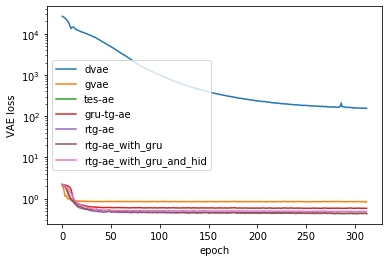

In [6]:
import matplotlib.pyplot as plt
plt.semilogy(learning_curves.T / M)
plt.legend(model_names)
plt.xlabel('epoch')
plt.ylabel('VAE loss')
plt.show()

### Store results

In [7]:
np.savetxt('results/%s_rmses.csv' % task, errors.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
np.savetxt('results/%s_runtimes.csv' % task, runtimes.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
np.savetxt('results/%s_learning_curves.csv' % task, learning_curves.T / M, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')

## Optimization

Finally, we perform optimization in the coding space of the best-performing model of every approach. In particular, we let CMA-ES run with an overall budget of 750 trees, i.e. the same budget as in the Work of [Kusner et al., 2017](http://proceedings.mlr.press/v70/kusner17a.html). The objective function is also the same as in Kusner et al., namely the penalized logp molecule characteristic, computed with the same code as in Kusner's work (disregarding some trivial changes to speed up computation).

However, to perform this optimization, we require models which are trained more intensively. So we know take the extra time of training for 50k molecules instead of 10k, just as in [Kusner et al., 2017](http://proceedings.mlr.press/v70/kusner17a.html).

In [5]:
# set op the hyper-parameters for optimization
T_opt = 1563
# take 56 latent dimensions as in Kusner et al., 2017
dim_vae_opt = 56

def setup_dvae():
    return dvae.DVAE(max_n = max_size + 2, nvt = len(types_idxs) + 2, hs = dim, nz = dim_vae_opt)
def setup_gvae():
    return gvae.GrammarVAE(smiles_data.grammar, dim = dim, max_len = max_size, dim_vae = dim_vae_opt, conv_params = conv_params, gru_dim = dim, num_gru_layers = gvae_layers)
def setup_tes_ae():
    return tesae.TESAutoEncoder(smiles_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
def setup_gru_tg_ae():
    return gru_tg_ae.RecurrentTreeAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae_opt)
def setup_rtg_ae():
    return rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae_opt)

from single_step_gru import SingleStepGRU
def setup_rtg_ae_with_gru():
    model = rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae_opt)
    model._dec._rules['Chain'][0]._child_layers[0] = SingleStepGRU(dim)
    return model
def setup_rtg_ae_with_gru_and_hid():
    model = rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_hid = dim_hid, dim_vae = dim_vae_opt)
    model._dec._rules['Chain'][0]._child_layers[0] = SingleStepGRU(dim)
    return model

setup_functions = [setup_dvae, setup_gvae, setup_tes_ae, setup_gru_tg_ae, setup_rtg_ae, setup_rtg_ae_with_gru, setup_rtg_ae_with_gru_and_hid]

In [9]:
import time
# try to load training indices
if os.path.exists('results/%s_optimization_train_idxs.csv' % task):
    # try to load crossvalidation folds
    train_idxs = np.loadtxt('results/%s_optimization_train_idxs.csv' % task, dtype=int)
    test_idxs = np.loadtxt('results/%s_optimization_test_idxs.csv' % task, dtype=int)
else:
    # get indices that were not already used in training
    remaining_idxs = np.setdiff1d(np.arange(dataset_size), samples_hyper)
    train_idxs     = np.random.choice(remaining_idxs, T_opt * N, replace = False)
    remaining_idxs = np.setdiff1d(remaining_idxs, train_idxs)
    test_idxs      = np.random.choice(remaining_idxs, N_test, replace = False)
    np.savetxt('results/%s_optimization_train_idxs.csv' % task, train_idxs, fmt='%d')
    np.savetxt('results/%s_optimization_test_idxs.csv'  % task, test_idxs, fmt='%d')

# try to load results
if os.path.exists('results/%s_optimization_train_results.csv' % task):
    Res = np.loadtxt('results/%s_optimization_train_results.csv' % task, delimiter='\t', skiprows = 1)
    errors = Res[0, :]
    runtimes = Res[1, :]
    learning_curves = Res[2:, :].T
else:
    errors   = np.full(len(model_names), np.nan)
    runtimes = np.zeros(len(model_names))
    learning_curves = np.zeros((len(model_names), T_opt))

# check which models have already been trained
models_left = np.argwhere(runtimes < 1E-3)[:, 0]

if len(models_left) > 1 or (len(models_left) == 1 and models_left[0] != 0):
    # sample trees in advance so that every model has the same training and test data
    training_data = []
    test_data = []
    with open(data_file) as f:
        for i, line in enumerate(f):
            if i in train_idxs:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                training_data.append((nodes, adj))
            if i in test_idxs:
                nodes, adj, _, _, _, _ = smiles_data.parse_smiles(line)
                test_data.append((nodes, adj))
    print('Sampled %d training trees' % len(training_data))
    print('Sampled %d test trees' % len(test_data))

# compute the remaining models
for model_idx in models_left:
    # TODO for now we ignore D-VAE because it takes too long to train (~13 days)
    if model_names[model_idx] == 'dvae':
        continue

    print('--- model %s ---' % model_names[model_idx])
    # set up the model
    model = setup_functions[model_idx]()

    start_time = time.time()
    if model_names[model_idx] != 'dvae' and model_names[model_idx] != 'tes-ae':
        # set up the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, verbose=True, min_lr=min_lr)
        # start training
        avg_loss = None
        for epoch in range(1, T_opt + 1):
            optimizer.zero_grad()
            # handle a minibatch of trees
            minibatch_loss = 0.
            for j in range(N*(epoch-1), N*epoch):
                nodes, adj = training_data[j]
                # compute auto-encoding loss
                loss = model.compute_loss(nodes, adj, beta = betas[model_idx], sigma_scaling = sigma_scalings[model_idx])
                loss.backward()
                minibatch_loss += loss.item()
            # compute gradient
            minibatch_loss /= N
            # perform an optimizer step
            optimizer.step()
            # apply the learning rate scheduler
            scheduler.step(minibatch_loss)
            # update the moving loss average
            learning_curves[model_idx, epoch-1] += minibatch_loss
            if avg_loss is None:
                avg_loss = minibatch_loss
            else:
                avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
            if(epoch % print_step == 0):
                print('loss avg after %d data points: %g' % (epoch * N, avg_loss))
    elif model_names[model_idx] == 'dvae':
        # use the special D-VAE training function with one epoch
        gs = []
        for nodes, adj in training_data:
            g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
            gs.append(g)
        learning_curve_dvae = dvae.train_dvae(model, gs, lr = learning_rate, epochs = 1, batch_size = N)
        # store the learning curve
        learning_curves[model_idx, :] += np.array(learning_curve_dvae)
    elif model_names[model_idx] == 'tes-ae':
        # use the special TES-AE training function
        model.fit_svm(training_data[:N_tesae])
    else:
        raise ValueError('internal error; unknown model name')
    runtimes[model_idx] = time.time() - start_time
    print('finished training after %g seconds' % runtimes[model_idx])
    # evaluate generalization
    sqe = 0.
    for nodes, adj in test_data:
        # encode the current test tree
        if len(model_names[model_idx]) < 4 or model_names[model_idx][:4] != 'dvae':
            _, z = model.encode(nodes, adj)
        else:
            g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
            z, _ = model.encode([g])
        # decode it again
        if len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'gvae':
            nodes_act, adj_act, _ = model.decode(z)
        elif len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'dvae':
            g_decoded   = model.decode(z)[0]
            nodes_act, adj_act = dvae.igraph_to_tree(g_decoded, types, True)
        else:
            nodes_act, adj_act, _ = model.decode(z, max_size = max_size)
        # check tree edit distance
        d = ted.ted(nodes, adj, nodes_act, adj_act)
        # accumulate it
        sqe += d * d
    rmse = np.sqrt(sqe / N_test)
    print('obtained RMSE of %g' % rmse)
    errors[model_idx] = rmse
    Res = np.concatenate([np.expand_dims(errors, 0), np.expand_dims(runtimes, 0), learning_curves.T])
    np.savetxt('results/%s_optimization_train_results.csv' % task, Res, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
    # store the rained model
    if model_names[model_idx] != 'tes-ae':
        torch.save(model.state_dict(), 'results/%s_optimization_%s.torch' % (task, model_names[model_idx]))
    else:
        joblib.dump(model, 'results/%s_optimization_%s.joblib' % (task, model_names[model_idx]))

In [10]:
# perform CMA-ES in the coding space to find optimal trees for the current task
import cma
import csv

verbose = True
invalid_const = 1000.

# set up the decoding functions for each model
def decode_dvae(h):
    g_decoded = model.decode(torch.tensor(h, dtype=torch.float).unsqueeze(0), stochastic = False)[0]
    nodes, adj = dvae.igraph_to_tree(g_decoded, types, True)
    return nodes, adj
def decode_gvae(h):
    nodes, adj, _ = model.decode(torch.tensor(h, dtype=torch.float))
    return nodes, adj
def decode_tes_ae(h):
    nodes, adj, _ = model.decode(h, max_size = 2*max_size)
    return nodes, adj
def decode_rtg_ae(h):
    nodes, adj, _ = model.decode(torch.tensor(h, dtype=torch.float), max_size = 2*max_size)
    return nodes, adj

decoding_functions = [decode_dvae, decode_gvae, decode_tes_ae, decode_rtg_ae, decode_rtg_ae, decode_rtg_ae, decode_rtg_ae]
if len(decoding_functions) != len(model_names):
    raise ValueError('Internal error: Expected one decoding function per model but got %d decoding functions for %d models' % (len(decoding_functions), len(model_names)))

# initialize the optimization results table
opt_trees = []
opt_F     = np.zeros((M, len(model_names)))
# check how many completed runs there are
if os.path.exists('results/%s_optimization.csv' % task):
    with open('results/%s_optimization.csv' % task) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        # skip the header row
        next(reader)
        # count the remaining rows
        run = 0
        for row in reader:
            opt_trees_run = []
            opt_trees.append(opt_trees_run)
            for model_idx in range(len(model_names)):
                opt_trees_run.append(row[model_idx])
                opt_F[run, model_idx] = row[len(model_names) + model_idx]
            run += 1

for run in range(len(opt_trees), M):
    print('--- optimization repeat %d of %d ---' % (run+1, M))
    opt_trees_run = []
    opt_trees.append(opt_trees_run)
    for model_idx in range(len(model_names)):
        # we ignore DVAE because it takes too long to train (~13 days)
        if model_names[model_idx] == 'dvae':
            opt_trees_run.append('')
            continue
        print('\n--- model %s ---' % model_names[model_idx])
        # load the special optimization model and setup the objective function
        if model_names[model_idx] != 'tes-ae':
            model = setup_functions[model_idx]()
            model.load_state_dict(torch.load('results/%s_optimization_%s.torch' % (task, model_names[model_idx])))
        else:
            model = joblib.load('results/%s_optimization_%s.joblib' % (task, model_names[model_idx]))
        # set up the objective function
        def objective_fun(h):
            try:
                # decode the vector via the decoding function
                nodes, adj = decoding_functions[model_idx](h)
                # return the objective function value
                return -smiles_data.objective_function(nodes, adj)
            except Exception as ex:
                # return a high constant value if anything goes wrong
                return invalid_const
        # because our models are variational auto-encoders, the optimal initial Gaussian
        # for CMA-ES should be a standard Gaussian
        if model_names[model_idx] == 'tes-ae':
            mu0    = np.zeros(dim)
        else:
            mu0    = np.zeros(dim_vae_opt)
        sigma0 = 1.
        # we set the parameter so that we have the same budget as Kusner et al. (2017)
        remaining_iters = 15
        h_opt = None
        f_opt = None
        # continue re-starting CMA-ES until we exceeded the budget
        while remaining_iters > 0:
            if verbose:
                print('Re-starting CMA-ES with %d remaining iterations' % remaining_iters)
            es = cma.CMAEvolutionStrategy(mu0, sigma0, {'popsize' : 50, 'verb_disp': 1 if verbose else 0, 'maxiter' : remaining_iters})
            # start the optimization
            es.optimize(objective_fun)
            # extract the result
            h = es.result[0]
            f = es.result[1]
            if f_opt is None or f < f_opt:
                f_opt = f
                h_opt = h
            remaining_iters -= es.result[4]
        # decode into a tree
        try:
            nodes, adj = decoding_functions[model_idx](h_opt)
            nodes, adj, ringbonds  = smiles_data.ringbond_heuristic(nodes, adj)
            tree_str   = smiles_data.to_smiles(nodes, adj, ringbonds = ringbonds)
            f_opt = smiles_data.objective_function(nodes, adj)
        except Exception as ex:
            f_opt = -invalid_const
        # print the objective function value
        print('CMA-ES found the following optimal tree: %s with evaluation %g' % (tree_str, f_opt))
        opt_trees_run.append(tree_str)
        opt_F[run, model_idx] = f_opt
    # write results to CSV
    with open('results/%s_optimization.csv' % task, 'w') as csvfile:
        write = csv.writer(csvfile, delimiter='\t', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        # write header
        csv_header = []
        for model_idx in range(len(model_names)):
            csv_header.append('%s_tree_opt' % model_names[model_idx])
        for model_idx in range(len(model_names)):
            csv_header.append('%s_f_opt' % model_names[model_idx])
        write.writerow(csv_header)
        # write one row per run
        for run2 in range(len(opt_trees)):
            row = []
            # write smiles string first
            for model_idx in range(len(model_names)):
                row.append(opt_trees[run2][model_idx])
            # then the objective function value
            for model_idx in range(len(model_names)):
                row.append(str(opt_F[run2, model_idx]))
            write.writerow(row)

## Visualization of the latent space

In the next cell, we visualize the latent space of the pre-trained model for optimization for randomly sampled molecules from the training data, reduced to two dimensions via t-SNE.

In [21]:
num_visualization_points = 10000
dim_vae_opt = 56

from sklearn.manifold import TSNE
import joblib

# sample num_visualization_points molecules at random and compute their
# objective function values

if os.path.exists('results/%s_samples_visualization.csv' % task):
    samples_vis = np.loadtxt('results/%s_samples_visualization.csv' % task, delimiter='\t', skiprows = 1)
    print('loaded %d sample indices from results/%s_samples_visualization.csv' % (len(samples_vis), task))
else:
    samples_vis = np.random.choice(dataset_size, num_visualization_points, replace = False)
    np.savetxt('results/%s_samples_visualization.csv' % task, samples_vis, header='index', fmt='%d', comments = '')

data_vis = []
objective_vis = np.zeros(len(samples_vis))

with open(data_file) as f:
    for i, smiles_str in enumerate(f):
        if i in samples_vis:
            nodes, adj, _, _, _, _ = smiles_data.parse_smiles(smiles_str)
            objective_vis[len(data_vis)] = smiles_data.compute_score(smiles_str)
            data_vis.append((nodes, adj))
print('Loaded %d training trees' % len(data_vis))

def setup_dvae():
    return dvae.DVAE(max_n = max_size + 2, nvt = len(types_idxs) + 2, hs = dim, nz = dim_vae_opt)
def setup_gvae():
    return gvae.GrammarVAE(smiles_data.grammar, dim = dim, max_len = max_size, dim_vae = dim_vae_opt, conv_params = conv_params, gru_dim = dim, num_gru_layers = gvae_layers)
def setup_tes_ae():
    return tesae.TESAutoEncoder(smiles_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
def setup_gru_tg_ae():
    return gru_tg_ae.RecurrentTreeAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae_opt)
def setup_rtg_ae():
    return rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae_opt)

from single_step_gru import SingleStepGRU
def setup_rtg_ae_with_gru():
    model = rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_vae = dim_vae_opt)
    model._dec._rules['Chain'][0]._child_layers[0] = SingleStepGRU(dim)
    return model
def setup_rtg_ae_with_gru_and_hid():
    model = rtg_ae.TreeGrammarAutoEncoder(smiles_data.grammar, dim = dim, dim_hid = dim_hid, dim_vae = dim_vae_opt)
    model._dec._rules['Chain'][0]._child_layers[0] = SingleStepGRU(dim)
    return model

setup_functions = [setup_dvae, setup_gvae, setup_tes_ae, setup_gru_tg_ae, setup_rtg_ae, setup_rtg_ae_with_gru, setup_rtg_ae_with_gru_and_hid]

Y = np.zeros((len(data_vis), len(model_names) * 2))

for model_idx in range(len(model_names)):
    # we ignore DVAE because it takes too long to train (~13 days)
    if model_names[model_idx] == 'dvae':
        continue
    print('\n--- model %s ---' % model_names[model_idx])
    # load the special optimization model
    if model_names[model_idx] != 'tes-ae':
        model = setup_functions[model_idx]()
        model.load_state_dict(torch.load('results/%s_optimization_%s.torch' % (task, model_names[model_idx])))
    else:
        model = joblib.load('results/%s_optimization_%s.joblib' % (task, model_names[model_idx]))
    # encode the molecules
    Z = []
    for i in range(len(data_vis)):
        _, z = model.encode(*data_vis[i])
        if model_names[model_idx] != 'tes-ae':
            Z.append(z.detach().numpy())
        else:
            Z.append(z)
    print('finished encoding; starting t-SNE')
    Z = np.array(Z)
    # perform dimensionality reduction via t-SNE
    Y[:, model_idx*2:model_idx*2+2] = TSNE(n_components=2).fit_transform(Z)
# write results to a CSV file
header = 'objective'
for model_name in model_names:
    header += '\t%s_x\t%s_y' % (model_name, model_name)
np.savetxt('results/%s_visualization.csv' % task, np.concatenate([np.expand_dims(objective_vis, 1), Y], 1), delimiter = '\t', header=header, fmt='%g', comments = '')

loaded 10000 sample indices from results/smiles_samples_visualization.csv
Loaded 10000 training trees

--- model gvae ---
finished encoding; starting t-SNE

--- model tes-ae ---
finished encoding; starting t-SNE

--- model gru-tg-ae ---
finished encoding; starting t-SNE

--- model rtg-ae ---
finished encoding; starting t-SNE

--- model rtg-ae_with_gru ---
finished encoding; starting t-SNE

--- model rtg-ae_with_gru_and_hid ---
finished encoding; starting t-SNE


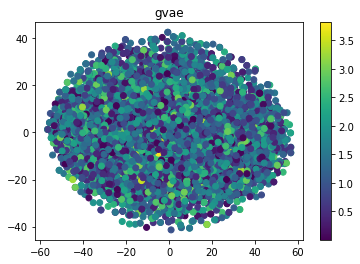

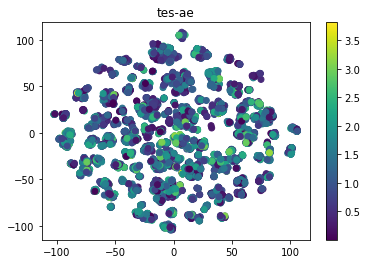

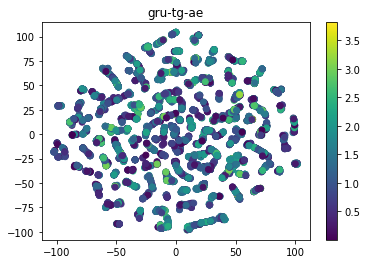

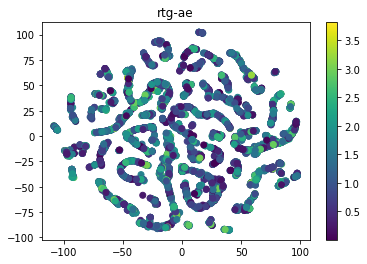

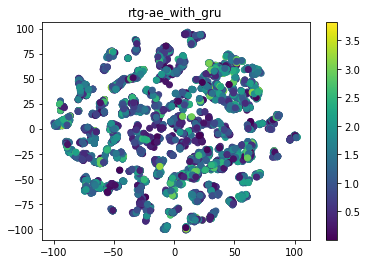

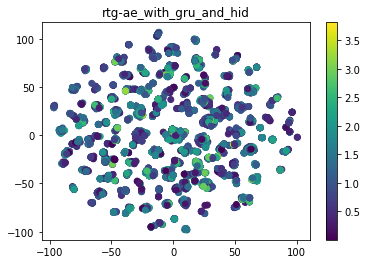

In [23]:
import matplotlib.pyplot as plt
for model_idx in range(len(model_names)):
    # we ignore DVAE because it takes too long to train (~13 days)
    if model_names[model_idx] == 'dvae':
        continue
    plt.scatter(Y[objective_vis > 0, 2*model_idx], Y[objective_vis > 0, 2*model_idx+1], c = objective_vis[objective_vis > 0])
    plt.colorbar()
    plt.title(model_names[model_idx])
    plt.show()

In [8]:
# print the number of parameters for all optimization models
import joblib
for model_idx in range(len(model_names)):
    # we ignore DVAE because it takes too long to train (~13 days)
    if model_names[model_idx] == 'dvae':
        continue
    # load the optimization model
    if model_names[model_idx] != 'tes-ae':
        model = setup_functions[model_idx]()
        model.load_state_dict(torch.load('results/%s_optimization_%s.torch' % (task, model_names[model_idx])))
    else:
        model = joblib.load('results/%s_optimization_%s.joblib' % (task, model_names[model_idx]))
        
    num_params = 0
    if model_names[model_idx] == 'tes-ae':
        for nont in smiles_data.grammar._nonts:
            num_params += dim * len(smiles_data.grammar._rules[nont])
    else:
        model = setup_functions[model_idx]()
        for key in model.state_dict():
            num_params += model.state_dict()[key].numel()
    print('%s: %d parameters' % (model_names[model_idx], num_params))

gvae: 1959231 parameters
tes-ae: 11776 parameters
gru-tg-ae: 467880 parameters
rtg-ae: 4863656 parameters
rtg-ae_with_gru: 5192616 parameters
rtg-ae_with_gru_and_hid: 1901576 parameters
